In this notebook, we use Generative Adversarial Network code (adapted from Rowel Atienza's under MIT License) to create sketches in the style of humans who have played the Quick, Draw! game (data available here under Creative Commons Attribution 4.0 license).

Separately, for reasons that escape us, the discriminator in this notebook nearly always fails to learn if you train on a CPU only. Because of this failure, the GAN will seldom learn how to generate sketches -- i.e., it will output images that are merely random noise. There are two ways we've identified to remedy this situation:

**Use a GPU.** If you don't have one, use Colab as suggested above. While in Colab, you can select "Change runtime type" from the "Runtime" item in the menu bar, and choose "GPU" as your hardware accelerator. This hardware accelerator trains the GAN orders of magnitude more rapidly than the "None" or "TPU" options, and the discriminator (we have no idea why!) will train properly.

**Change the discriminator's optimizer**. As noted by a comment in this notebook's discriminator compilation step, switching from the default RMSprop optimizer to another (e.g., Adam or AdaDelta) enables the discriminator to learn effectively and therefore the GAN generates sketches. Whether you use a CPU only, a GPU, or a TPU, this solution is effective. (That said, training the GAN with a GPU is still way faster than with a CPU only or a TPU.)

## **Load Dependencies**

In [233]:
import numpy as np
import os

# for deep learning
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import RMSprop

#for plotting
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline



## **Loading the Data**

In [234]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/quickdraw_data')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [235]:
input_images = "../quickdraw_data/full_numpy_bitmap_apple.npy"

In [236]:
data = np.load(input_images)

In [237]:
data.shape

(144722, 784)

In [238]:
data[4242]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  36,  79,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 134, 238,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 119, 254,   4,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 101, 255,  21,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  82, 255,  39,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [239]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1)) # fourth dimension is color
img_w,img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

In [240]:
data[4242]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.14117647],
        [0.30980392],
        [0.        ],
        [0.        ],
        

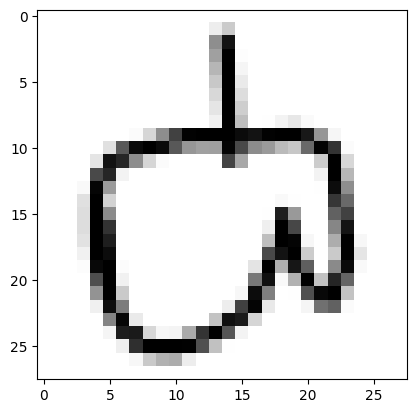

In [241]:
plt.imshow(data[4242,:,:,0], cmap='Greys')


## **Create discriminator network**

In [272]:
from keras.layers import LeakyReLU

def build_discriminator(depth=64, p=0.4):
    image = Input((img_w, img_h, 1))

    x = Conv2D(depth, kernel_size=5, strides=2, padding='same')(image)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(p)(x)

    x = Conv2D(depth*2, kernel_size=5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(p)(x)

    x = Conv2D(depth*4, kernel_size=5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(p)(x)

    x = Conv2D(depth*8, kernel_size=5, strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(p)(x)

    x = Flatten()(x)
    prediction = Dense(1, activation='sigmoid')(x)  # Use 'linear' if using WGAN

    model = Model(inputs=image, outputs=prediction)
    return model

In [273]:
discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [274]:
discriminator.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_93 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_94 (Dropout)                 │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 4, 4, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_95 (Dropout)                 │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 4, 4, 512)           │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_96 (Dropout)                 │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,311,553 (16.45 MB)

 Trainable params: 4,311,553 (16.45 MB)

 Non-trainable params: 0 (0.00 B)

In [245]:
#discriminator.compile(loss='binary_crossentropy',
#                      optimizer=RMSprop(learning_rate=0.0002,
#                                        weight_decay=1e-8,
#                                        clipvalue=1.0),
#                      metrics=['accuracy'])

In [275]:
from keras.optimizers import Adam

discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    metrics=['accuracy']
)

## **Create generator network**

In [276]:
z_dimensions = 32

In [271]:
def build_generator(latent_dim=32, depth=64, p=0.3):
    noise = Input((latent_dim,))

    x = Dense(7 * 7 * depth)(noise)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Reshape((7, 7, depth))(x)

    x = UpSampling2D()(x)  # 14x14
    x = Conv2DTranspose(depth // 2, kernel_size=5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)  # 28x28
    x = Conv2DTranspose(depth // 4, kernel_size=5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(depth // 8, kernel_size=5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)

    image = Conv2D(1, kernel_size=5, padding='same', activation='tanh')(x)

    return Model(inputs=noise, outputs=image)

In [277]:
generator = build_generator()

In [278]:
generator.summary()

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)          │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 3136)                │         103,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 3136)                │          12,544 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_56 (Activation)           │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_14 (Reshape)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_28 (UpSampling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_42                  │ (None, 14, 14, 32)          │          51,232 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_57 (Activation)           │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_29 (UpSampling2D)      │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_43                  │ (None, 28, 28, 16)          │          12,816 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_58 (Activation)           │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_44                  │ (None, 28, 28, 8)           │           3,208 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 28, 28, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_59 (Activation)           │ (None, 28, 28, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 28, 28, 1)           │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,713 (717.63 KB)

 Trainable params: 177,329 (692.69 KB)

 Non-trainable params: 6,384 (24.94 KB)

## **Create adversarial network**

In [279]:
z = Input(shape=(z_dimensions,))
img = generator(z)

In [252]:
discriminator.trainable = False

In [253]:
pred = discriminator(img)

In [254]:
adversarial_model = Model(z, pred)

In [280]:
adversarial_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    metrics=['accuracy']
)

In [256]:
#adversarial_model.compile(loss='binary_crossentropy',
#                          optimizer=Adam(learning_rate=0.0004,
#                                            clipvalue=1.0),
#                          metrics=['accuracy'])

## **Train!**

In [283]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    d_metrics = []
    a_metrics = []

    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0

    for i in range(epochs):
        # Sample real images and normalize
        idx = np.random.choice(data.shape[0], batch, replace=False)
        real_imgs = np.reshape(data[idx], (batch, 28, 28, 1))

        # Generate fake images
        noise = np.random.uniform(-1.0, 1.0, size=[batch, z_dim])
        fake_imgs = generator.predict(noise)

        # Labels (with label smoothing)
        real_labels = np.ones((batch, 1)) * 0.9
        fake_labels = np.zeros((batch, 1))

        # Combine real and fake data
        x = np.concatenate((real_imgs, fake_imgs))
        y = np.concatenate((real_labels, fake_labels))

        # Optional: shuffle for better training
        idx = np.arange(2 * batch)
        np.random.shuffle(idx)
        x = x[idx]
        y = y[idx]

        # Train discriminator
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x, y)
        d_metrics.append(d_loss)
        running_d_loss += d_loss[0]
        running_d_acc += d_loss[1]

        # Train generator (via adversarial model)
        noise = np.random.uniform(-1.0, 1.0, size=[batch, z_dim])
        y_gen = np.ones((batch, 1))  # tricking D into thinking G's images are real

        discriminator.trainable = False
        a_loss = adversarial_model.train_on_batch(noise, y_gen)
        a_metrics.append(a_loss)
        running_a_loss += a_loss[0]
        running_a_acc += a_loss[1]

        # Show progress and images every 100 epochs
        if (i + 1) % 100 == 0:
            print(f'Epoch #{i+1}')
            log_mesg = f"{i+1}: [D loss: {running_d_loss/(i+1):.4f}, acc: {running_d_acc/(i+1)*100:.2f}%]"
            log_mesg += f" [A loss: {running_a_loss/(i+1):.4f}, acc: {running_a_acc/(i+1)*100:.2f}%]"
            print(log_mesg)

            gen_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[16, z_dim]))
            plt.figure(figsize=(5, 5))
            for k in range(16):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
            plt.tight_layout()
            plt.show()

    return a_metrics, d_metrics

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━

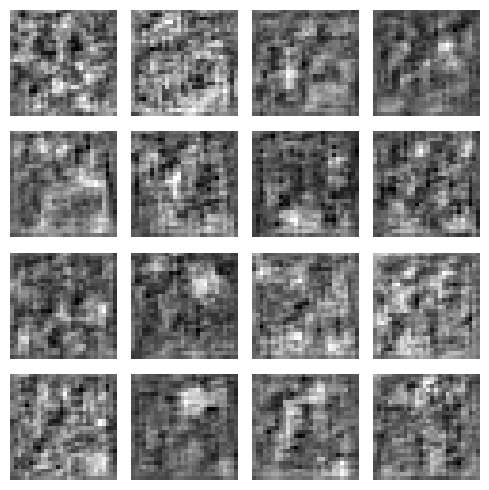

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

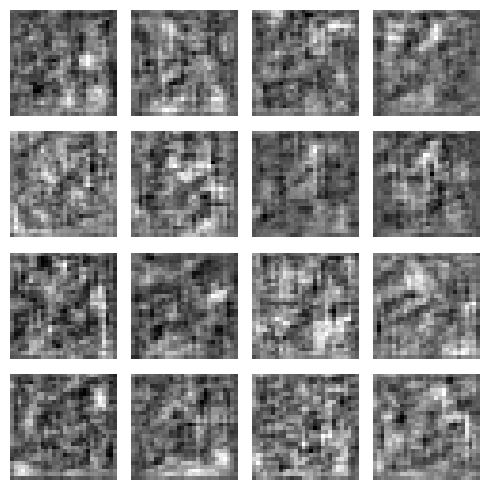

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

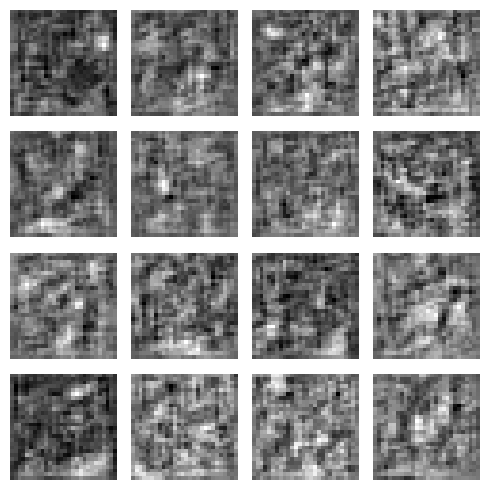

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

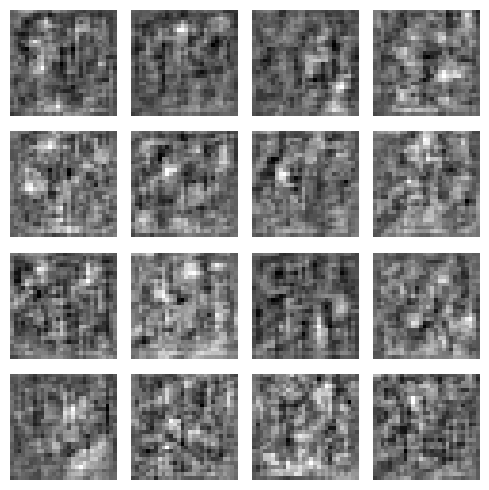

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

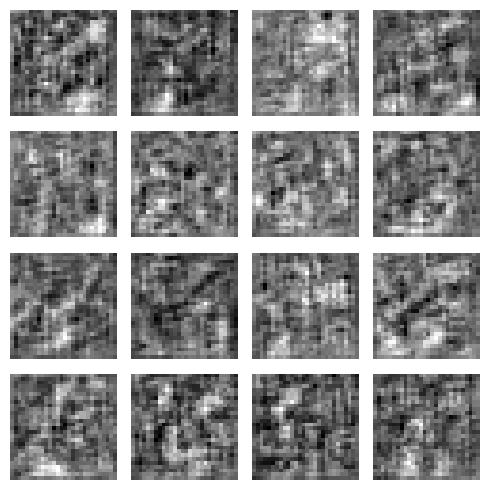

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

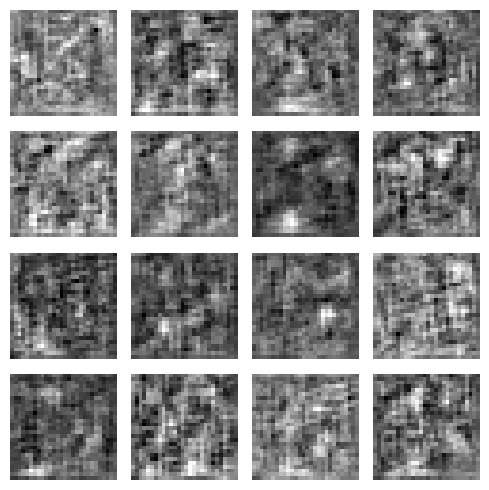

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

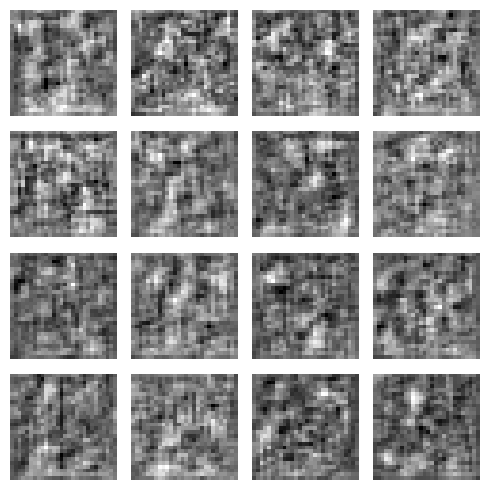

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

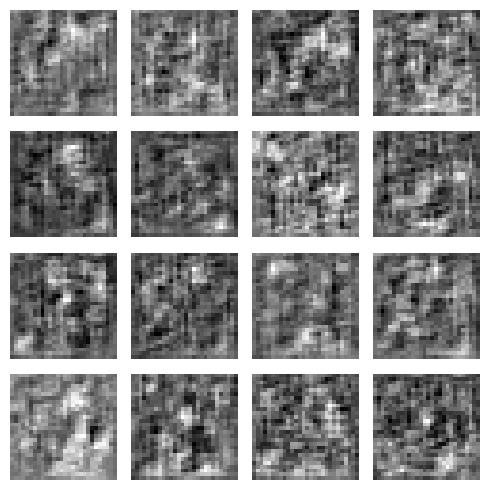

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━

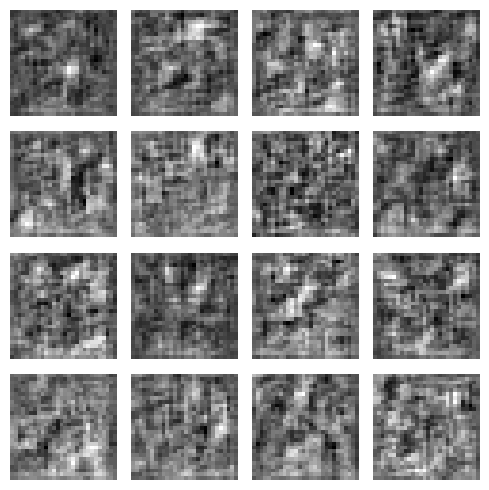

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━

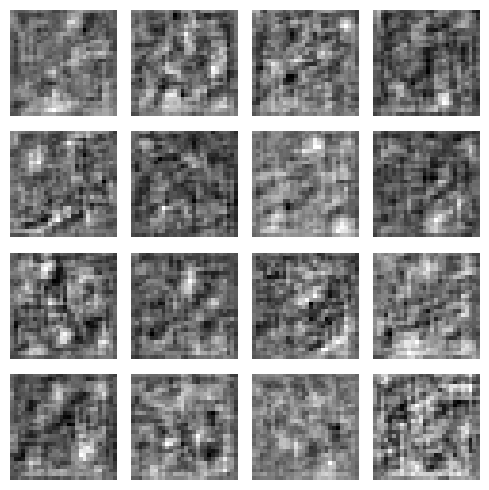

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━

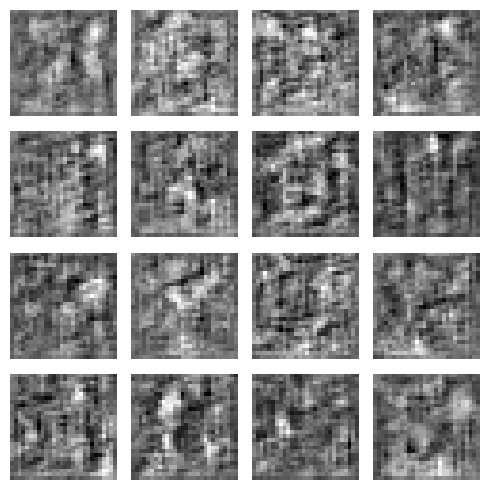

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━

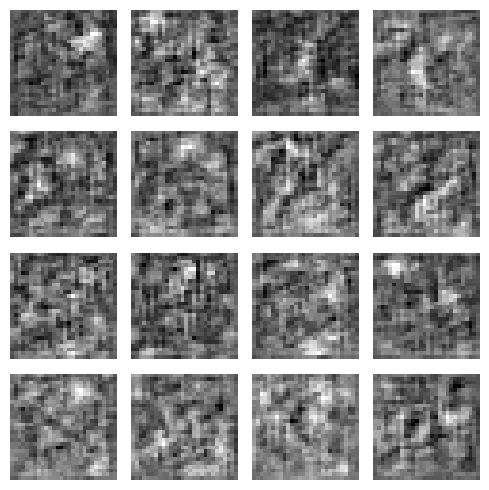

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━

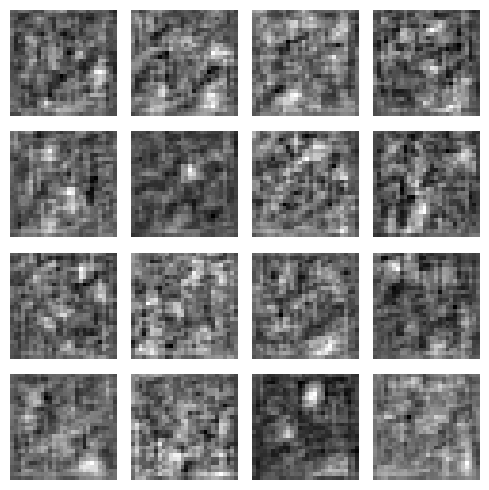

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

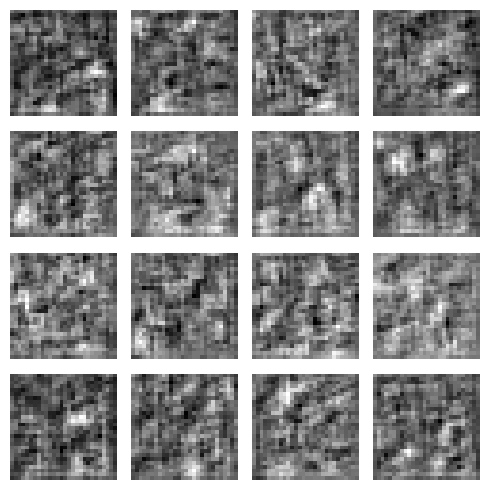

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

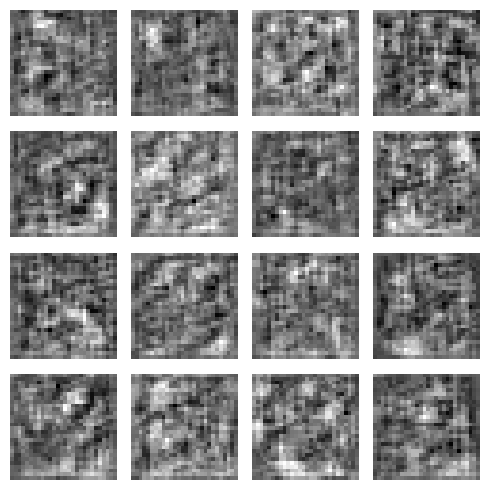

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

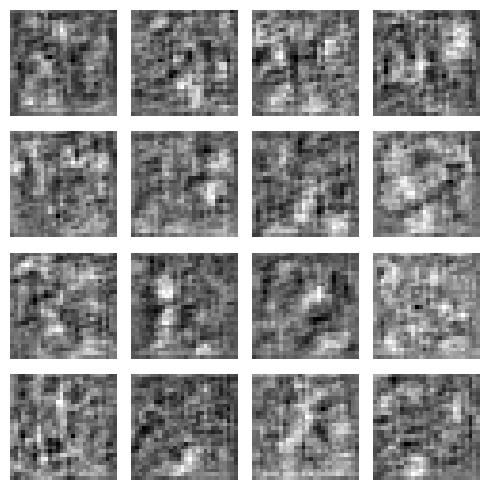

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━

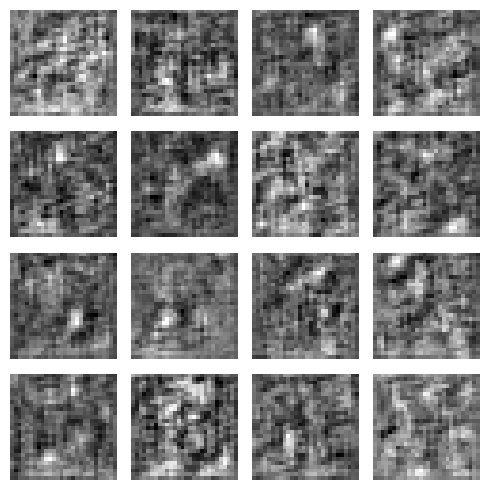

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━

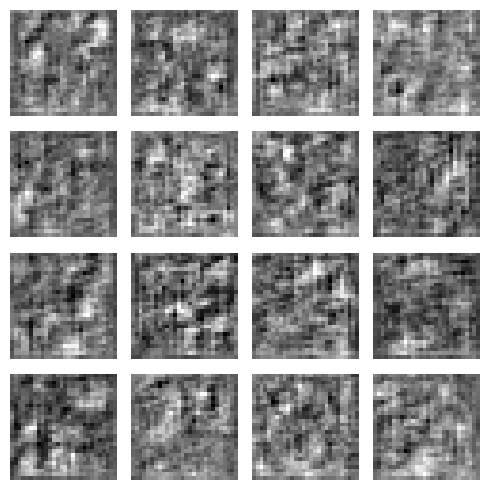

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━

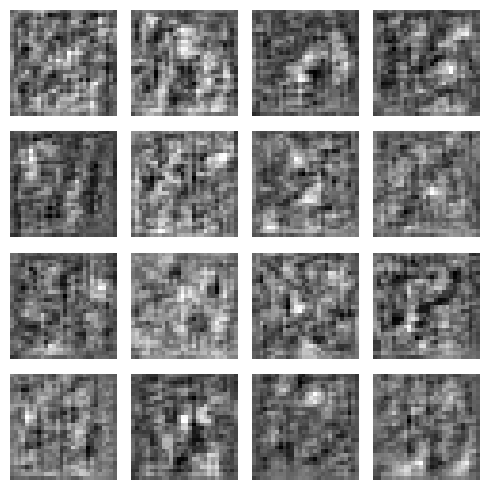

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━

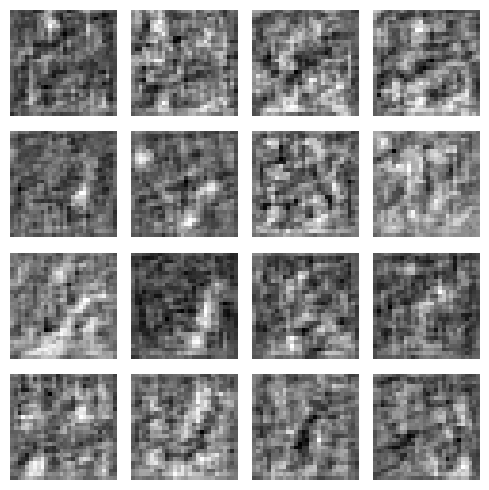

In [284]:
a_metrics_complete, d_metrics_complete = train()

Text(0, 0.5, 'Loss')

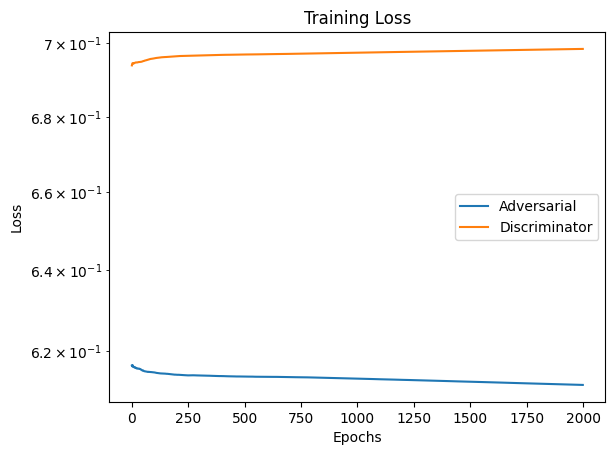

In [259]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[0].item() for metric in a_metrics_complete], # Extract the first element (loss) and convert it to a native Python number
        'Discriminator': [metric[0].item() for metric in d_metrics_complete], # Extract the first element (loss) and convert it to a native Python number
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

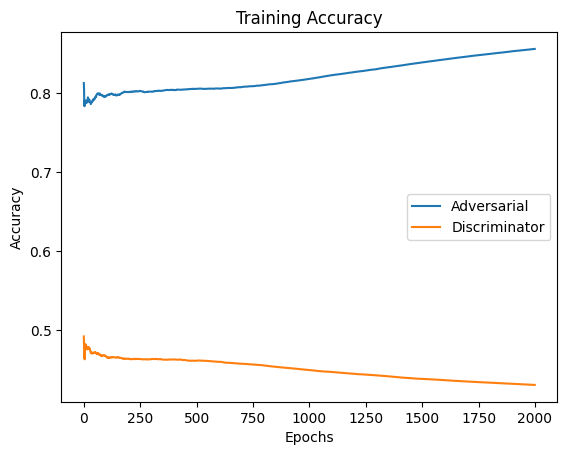

In [260]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1].item() for metric in a_metrics_complete],
        'Discriminator': [metric[1].item() for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")